<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2

Автор материала: Data Science интерн Ciklum, студент магистерской программы CSDS UCU Виталий Радченко, программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание №5
## <center> Случайный лес и логистическая регрессия в задачах кредитного скоринга и классификации отзывов к фильмам

#### Нашей главной задачей будет построение и настройка моделей для задач кредитного скоринга и анализа отзывов к фильмам. Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/7nbdvV).

Но для разминки решите первое задание.

**<font color='red'>Задание 1.</font>** В зале суда есть 7 присяжных, каждый из них по отдельности с вероятностью 80% может правильно определить, виновен подсудимый или нет. С какой вероятностью присяжные все вместе вынесут правильный вердикт, если решение принимается большинством голосов?

**<font color='red'>Варианты ответа:</font>**
- 20.97%
- 80.00%
- 83.70%
- 96.66%

Теперь перейдем непосредственно к машинному обучению.

#### Данные по кредитному скорингу представлены следующим образом:

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	– Человек имел долгие просрочки выплат платежей за 2 года; бинарный признак

##### Независимые признаки
* age	                         – Возраст заёмщика кредитных средств (число полных лет); тип – integer
* NumberOfTime30-59DaysPastDueNotWorse	– Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней (но не больше) в течение последних двух лет; тип -	integer
* DebtRatio –	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип – float
* MonthlyIncome	– Месячный доход в долларах; тип –	float
* NumberOfTimes90DaysLate – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип –	integer
* NumberOfTime60-89DaysPastDueNotWorse –	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней (но не больше) в течение последних двух лет; тип – integer
* NumberOfDependents – Число человек в семье кредитозаёмщика; тип –	integer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Напишем функцию, которая будет заменять значения NaN на медиану в каждом столбце таблицы. 

In [2]:
def impute_nan_with_median(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

Считываем данные

In [3]:
data = pd.read_csv('D:\\Yorko\\credit_scoring_sample.csv', sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [5]:
import sklearn
sklearn.__version__

'0.19.0'

Рассмотрим типы считанных данных

In [6]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Посмотрим на распределение классов в зависимой переменной

Distribution of target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

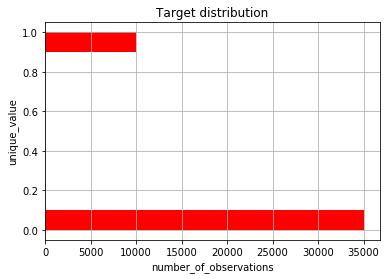

In [7]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target:')
data['SeriousDlqin2yrs'].value_counts() / data.shape[0]

Выберем названия всех признаков, кроме прогнозируемого

In [8]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Применяем функцию, заменяющую все значения NaN на медианное значение соответствующего столбца.

In [9]:
table = impute_nan_with_median(data)

Разделяем целевой признак и все остальные – получаем обучающую выборку. 

In [10]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

# Бутстрэп

**<font color='red'>Задание 2.</font>** Сделайте интервальную оценку (на основе бутстрэпа) среднего дохода (MonthlyIncome) клиентов, просрочивших выплату кредита, и отдельно – для вовремя заплативших. Стройте 90% доверительный интервал. Найдите разницу между нижней границей полученного интервала для не просрочивших кредит и верхней границей – для просрочивших. 
То есть вас просят построить 90%-ые интервалы для дохода "хороших" клиентов $[good\_income\_lower, good\_income\_upper]$ и для "плохих" – $[bad\_income\_lower, bad\_income\_upper]$ и найти разницу $good\_income\_lower - bad\_income\_upper$.

Используйте пример из [статьи](https://habrahabr.ru/company/ods/blog/324402/). Поставьте `np.random.seed(17)`. Округлите ответ до целых.

**<font color='red'>Варианты ответа:</font>**
- 345
- 425
- 585
- 655

In [11]:
print(len(data))
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

45063


In [12]:
Xplus = X[y==1]
Xminus = X[y==0]
print(len(Xplus), len(Xminus))

10026 35037


In [19]:
np.random.seed(17)
valplus = [np.mean(sample) for sample in get_bootstrap_samples(Xplus.MonthlyIncome.values, 1000)]

In [20]:
np.random.seed(17)
valminus = [np.mean(sample) for sample in get_bootstrap_samples(Xminus.MonthlyIncome.values, 1000)]

In [21]:
print("valplus",  stat_intervals(valplus, 0.1))
print("valminus",  stat_intervals(valminus, 0.1))
print(6293.33189485-5647.17716437)
print(6295.93237577-5641.20421404)

valplus [ 5462.17301516  5641.20421404]
valminus [ 6295.93237577  6505.35467934]
646.1547304799997
654.7281617300005


# Дерево решений, подбор гиперпараметров

Одной из основных метрик качества модели является площадь под ROC-кривой. Значения ROC-AUC лежат от 0 до 1. Чем ближе значение ROC-AUC к 1, тем качественнее происходит классификация моделью.

Найдите с помощью `GridSearchCV` гиперпараметры `DecisionTreeClassifier`, максимизирующие площадь под ROC-кривой. 

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Используем модуль `DecisionTreeClassifier` для построения дерева решений. Из-за несбалансированности классов  в целевом признаке добавляем параметр балансировки. Используем также параметр `random_state=17` для воспроизводимости результатов.

In [23]:
dt = DecisionTreeClassifier(random_state=17, class_weight='balanced')

Перебирать будем вот такие значения гиперпараметров:

In [24]:
max_depth_values = [5, 6, 7, 8, 9]
max_features_values = [4, 5, 6, 7]
tree_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

Зафиксируем кросс-валидацию: стратифицированная, 5 разбиений с перемешиванием, не забываем про `random_state`.

In [25]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

**<font color='red'>Задание 3.</font>**
Сделайте GridSearch с метрикой ROC AUC по гиперпараметрам из словаря `tree_params`. Какое максимальное значение ROC AUC получилось (округлите до 2 знаков после разделителя)? Назовем кросс-валидацию устойчивой, если стандартное отклонение метрики качества на кросс-валидации меньше 1%. Получилась ли кросс-валидация устойчивой при оптимальных сочетаниях гиперпараметров (т.е. обеспечивающих максимум среднего значения ROC AUC на кросс-валидации)?

**<font color='red'>Варианты ответа:</font>**
- 0.82, нет
- 0.84, нет
- 0.82, да
- 0.84, да

In [26]:
mod = GridSearchCV(dt, tree_params, cv = skf, scoring="roc_auc")
mod.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [4, 5, 6, 7], 'max_depth': [5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [27]:
mod.best_score_

0.82030234762096355

In [28]:
mod.best_params_

{'max_depth': 7, 'max_features': 6}

In [29]:
mod.cv_results_

{'mean_fit_time': array([ 0.03560095,  0.03780046,  0.04320006,  0.05440106,  0.03880129,
         0.04480214,  0.04940186,  0.05200009,  0.03840013,  0.05000134,
         0.06100245,  0.06540012,  0.04800229,  0.05580273,  0.05920005,
         0.0650001 ,  0.04700012,  0.05560007,  0.06360011,  0.07100015]),
 'mean_score_time': array([ 0.00200009,  0.00259995,  0.002     ,  0.00359993,  0.0026001 ,
         0.00240011,  0.00280004,  0.002     ,  0.00299997,  0.00360012,
         0.00180006,  0.002     ,  0.00260019,  0.00360022,  0.00300002,
         0.00200005,  0.004     ,  0.004     ,  0.00399995,  0.00200005]),
 'mean_test_score': array([ 0.81089154,  0.8043939 ,  0.81111502,  0.81487177,  0.81574356,
         0.81615275,  0.8146449 ,  0.81903996,  0.81754694,  0.81685585,
         0.82030235,  0.81903131,  0.81448767,  0.81661305,  0.8148858 ,
         0.8163828 ,  0.80887829,  0.81197468,  0.80964848,  0.80987945]),
 'mean_train_score': array([ 0.81587911,  0.81126242,  0.817486

# Простая реализация случайного леса

**<font color='red'>Задание 4.</font>**
Реализуйте свой собственный случайный лес с помощью `DecisionTreeClassifier` с лучшими параметрами из прошлого задания. В нашем лесу будет 10 деревьев, предсказанные вероятности которых вам нужно усреднить. 

Краткая спецификация: 
 - Используйте основу ниже
 - В методе `fit` в цикле (`i` от 0 до `n_estimators-1`) фиксируйте seed, равный (`random_state + i`). Почему именно так – неважно, главное чтоб на каждой итерации seed был новый, при этом все значения можно было бы воспроизвести
 - Зафиксировав seed, выберите **без замещения** `max_features` признаков, сохраните список выбранных id признаков в `self.feat_ids_by_tree`
 - Также сделайте bootstrap-выборку (т.е. **с замещением**) из множества id объектов 
 - Обучите дерево с теми же `max_depth`, `max_features` и `random_state`, что и у `RandomForestClassifierCustom` на выборке с нужным подмножеством объектов и признаков
 - Метод `fit` возвращает текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self`
 - В методе `predict_proba` опять нужен цикл по всем деревьям. У тестовой выборки нужно взять те признаки, на которых соответсвующее дерево обучалось, и сделать прогноз вероятностей (`predict_proba` уже для дерева). Метод должен вернуть усреднение прогнозов по всем деревьям.

Проведите кросс-валидацию. Какое получилось среднее значение ROC AUC на кросс-валидации? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.823
- 0.833
- 0.843
- 0.853

In [43]:
from sklearn.model_selection import cross_val_score

from sklearn.base import BaseEstimator

class RandomForestClassifierCustom(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=3, max_features=10, random_state=17):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        # в данном списке будем хранить отдельные деревья
        self.trees = []
        # тут будем хранить списки индексов признаков, на которых обучалось каждое дерево 
        self.feat_ids_by_tree = []
        
    def fit(self, X, y):
        X = X.reset_index(drop = True)
        y = y.reset_index(drop = True)
        for i in range(self.n_estimators):
            np.random.seed(self.random_state+i)
            feats = np.random.choice(X.shape[1], self.max_features, replace = False)
            #print(i)
            #print(feats)
            #print(X.head())
            #print(X.columns[feats])
            #print(X.iloc[:, feats].head())
            self.feat_ids_by_tree.append(feats)
            ids = np.random.choice(X.index, len(X), replace = True)
            model = DecisionTreeClassifier(max_depth = self.max_depth, max_features = self.max_features, random_state = self.random_state, class_weight='balanced')
            #print(ids[0:10])
            #print(len(X), len(ids))
            model.fit(X.iloc[ids, feats], y[ids])
            self.trees.append(model)
        return(self) 
    
    def predict_proba(self, X):
        for i in range(self.n_estimators):
            model = self.trees[i]
            features = self.feat_ids_by_tree[i]
            res = model.predict_proba(X.iloc[:, features])
            res = pd.DataFrame(res)
            print(i)
            if i==0:
                restot = res
            else:
                restot += res
        restot = restot/self.n_estimators
        return(restot.values)


In [44]:
model = RandomForestClassifierCustom(max_depth=7, max_features=6)
#model.fit(X, y)

In [79]:
#rrr=model.predict_proba(X)

0
1
2
3
4
5
6
7
8
9


In [45]:
mod = GridSearchCV(model, {'max_depth': [7],
               'max_features': [6]}, cv = skf, scoring="roc_auc")
mod.fit(X, y)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifierCustom(max_depth=7, max_features=6, n_estimators=10,
               random_state=17),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [6], 'max_depth': [7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [33]:
mod.cv_results_

{'mean_fit_time': array([ 0.50541492]),
 'mean_score_time': array([ 0.05640082]),
 'mean_test_score': array([ 0.83239683]),
 'mean_train_score': array([ 0.84368224]),
 'param_max_depth': masked_array(data = [7],
              mask = [False],
        fill_value = ?),
 'param_max_features': masked_array(data = [6],
              mask = [False],
        fill_value = ?),
 'params': [{'max_depth': 7, 'max_features': 6}],
 'rank_test_score': array([1]),
 'split0_test_score': array([ 0.83420888]),
 'split0_train_score': array([ 0.8439351]),
 'split1_test_score': array([ 0.8328212]),
 'split1_train_score': array([ 0.84300348]),
 'split2_test_score': array([ 0.82973073]),
 'split2_train_score': array([ 0.84423924]),
 'split3_test_score': array([ 0.83564878]),
 'split3_train_score': array([ 0.84374456]),
 'split4_test_score': array([ 0.82957413]),
 'split4_train_score': array([ 0.84348881]),
 'std_fit_time': array([ 0.01772151]),
 'std_score_time': array([ 0.06432261]),
 'std_test_score': array(

In [46]:
(mod.cv_results_['split0_test_score']+ mod.cv_results_['split1_test_score'] +mod.cv_results_['split2_test_score']+ mod.cv_results_['split3_test_score'] + mod.cv_results_['split4_test_score'])/5

array([ 0.83143253])

**<font color='red'>Задание 5.</font>**
Тут сравним нашу собственную реализацию случайного леса с `sklearn`-овской. Для этого воспользуйтесь `RandomForestClassifier(n_jobs=1, random_state=17)`, укажите все те же значения `max_depth` и `max_features`, что и раньше. Какое среднее значение ROC AUC на кросс-валидации мы в итоге получили? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.823
- 0.833
- 0.843
- 0.853

In [47]:
from sklearn.ensemble import RandomForestClassifier
coolmod = RandomForestClassifier(n_jobs = 1, random_state = 17, max_depth = 7, max_features = 6, class_weight='balanced')

In [48]:
mod = GridSearchCV(coolmod, {'max_depth': [7],
               'max_features': [6]}, cv = skf, scoring="roc_auc")
mod.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=7, max_features=6,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=17,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [6], 'max_depth': [7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [49]:
mod.best_score_

0.82914371735782066

In [38]:
(mod.cv_results_['split0_test_score']+ mod.cv_results_['split1_test_score'] +mod.cv_results_['split2_test_score']+ mod.cv_results_['split3_test_score'] + mod.cv_results_['split4_test_score'])/5

array([ 0.83051972])

# Случайный лес `sklearn`, подбор гиперпараметров

**<font color='red'>Задание 6.</font>** 
В 3 задании мы находили оптимальные гиперпараметры для одного дерева, но может быть, для ансамбля эти параметры дерева не будут оптимальными. Давайте проверим это с помощью `GridSearchCV` `(RandomForestClassifier(random_state=17)`).  Только теперь расширим перебираемые занчения `max_depth` до 15 включительно, так как в лесу нужны деревья поглубже (а почему именно – вы поняли из [статьи](https://habrahabr.ru/company/ods/blog/324402/)). Какими теперь стали лучшие значения гиперпараметров?

**<font color='red'>Варианты ответа:</font>**
- `max_depth=8, max_features=4`
- `max_depth=9, max_features=5`
- `max_depth=10, max_features=6`
- `max_depth=11, max_features=7`

In [50]:
#max_depth_values = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
max_depth_values = [8, 9, 10, 11]
max_features_values = [4, 5, 6, 7]
forest_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

In [51]:
coolmod = RandomForestClassifier(n_jobs = 1, random_state = 17, n_estimators=10, class_weight='balanced')
mod = GridSearchCV(coolmod, forest_params, scoring="roc_auc", cv = skf)
mod.fit(X, y)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=17,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [4, 5, 6, 7], 'max_depth': [8, 9, 10, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [52]:
mod.best_params_

{'max_depth': 8, 'max_features': 4}

In [53]:
#mod.cv_results_
#0.83302913 ####0.83357997
#0.83295069
#0.83120865
#0.83006078
import sklearn
sklearn.__version__


'0.19.0'

# Логистическая регрессия, подбор гиперпараметров

**<font color='red'>Задание 7.</font>**  Теперь сравним с логистической регрессией (укажем `class_weight='balanced'` и `random_state=17`). Сделайте полный перебор по параметру `C` из широкого диапазона значений `np.logspace(-8, 8, 17)`. 
Только сделаем это корректно и выстроим пайплайн – сначала масштабирование, затем обучение модели. 

Разберитесь с пайплайнами и проведите кросс-валидацию. Какое получилось лучшее значение средней ROC AUC? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.778
- 0.788
- 0.798
- 0.808

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
logit = LogisticRegression(random_state=17, class_weight='balanced')

logit_pipe = Pipeline([('scaler', scaler), ('logit', logit)])
logit_pipe_params = {'logit__C': np.logspace(-8, 8, 17)}

In [55]:
mod = GridSearchCV(logit_pipe, logit_pipe_params, scoring="roc_auc", cv = skf)
mod.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logit', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logit__C': array([  1.00000e-08,   1.00000e-07,   1.00000e-06,   1.00000e-05,
         1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01,   1.00000e+02,   1.00000e+03,
         1.00000e+04,   1.00000e+05,   1.00000e+06,   1.00000e+07,
         1.00000e+08])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [56]:
mod.best_score_

0.78786267573072055

# Логистическая регрессия и случайный лес на разреженных признаках

В случае небольшого числа признаков случайный лес показал себя лучше логистической регрессии. Однако один из главных недостатков деревьев проявляется при работе с разреженным данными, например с текстами. Давайте сравним логистическую регрессию и случайный лес в новой задаче.
Скачайте данные с отзывами к фильмам [отсюда](https://yadi.sk/d/pHZlDkg-3NSUQW).

In [57]:
# Загрузим данные
df = pd.read_csv("D:\\movie_reviews_train.csv", nrows=50000)

# Разделим данные на текст и целевой признак
X_text = df["text"]
y_text = df["label"]

# Соотношения классов
df.label.value_counts()

1    32492
0    17508
Name: label, dtype: int64

In [58]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# будем разбивать на 3 фолда
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

# в Pipeline будем сразу преобразовать наш текст и обучать логистическую регрессию
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features = 100000, ngram_range = (1, 3))),
    ('clf', LogisticRegression(random_state=17))])

**<font color='red'>Задание 8.</font>** Сделайте полный перебор по параметру `C` из выборки [0.1, 1, 10, 100]. Какое лучшее значение ROC AUC получилось на кросс-валидации? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.74
- 0.75
- 0.84
- 0.85

In [59]:
mod = GridSearchCV(classifier, {'clf__C': [0.1, 1, 10, 100]}, scoring="roc_auc", cv = skf)
mod.fit(X_text, y_text)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
     ...alty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__C': [0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

In [60]:
mod.best_score_

0.8586927867270796

**<font color='red'>Задание 9.</font>** Теперь попробуем сравнить со случайным лесом. Аналогично делаем перебор и получаем максимальное ROC AUC. Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.74
- 0.75
- 0.84
- 0.85

In [61]:
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features = 100000, ngram_range = (1, 3))),
    ('clf', RandomForestClassifier(random_state=17, n_jobs=-1))])

min_samples_leaf = [1, 2, 3]
max_features = [0.3, 0.5, 0.7]
max_depth = [None]

In [62]:
mod = GridSearchCV(classifier, {'clf__min_samples_leaf': min_samples_leaf,
                               'clf__max_features': max_features,
                               'clf__max_depth': max_depth}, scoring="roc_auc", cv = skf)
mod.fit(X_text, y_text)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
     ...timators=10, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__max_features': [0.3, 0.5, 0.7], 'clf__min_samples_leaf': [1, 2, 3], 'clf__max_depth': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [63]:
mod.best_score_

0.74727464051458781